In [ ]:
!unzip hacka-aka-embedika.zip

In [ ]:
!sudo apt-get update
!sudo apt-get install python-dev libxml2-dev libxslt1-dev antiword unrtf poppler-utils pstotext tesseract-ocr \
flac ffmpeg lame libmad0 libsox-fmt-mp3 sox libjpeg-dev swig libpulse-dev

In [1]:
!pip3 install textract imbalanced-learn 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.9 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 53.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 73.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.5/128.5 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
from pathlib import Path
import textract
from tqdm import tqdm
tqdm.pandas()
import re
import numpy as np
import seaborn as sns

device='cuda'

In [3]:
df = pd.DataFrame(pd.read_json('classes.json',typ='series')).reset_index()
df.columns = ['doc','class_name']
df['type'] = df['class_name'].replace(df['class_name'].unique(),[0,1,2,3,4])
df['original_text'] = None

for i,d in tqdm(df.iterrows()):
    doc_path = Path.cwd()/'docs'/d.doc
    doc_type = d.doc.split('.')[-1]
    text = textract.process(str(doc_path))
    df['original_text'].loc[i] = text.decode('utf-8')

df.head()

0it [00:00, ?it/s]/tmp/ipykernel_78/1540328009.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_text'].loc[i] = text.decode('utf-8')
1it [00:00,  5.45it/s]/tmp/ipykernel_78/1540328009.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_text'].loc[i] = text.decode('utf-8')
2it [00:00,  6.65it/s]/tmp/ipykernel_78/1540328009.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_text'].loc[i] = te

,doc,class_name,type,original_text
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки,0,\n\n ДОГОВОР\n\n\n\n\n |г. Москв...
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки,0,\n\n\n Договор №____...
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Договоры для акселератора/Договоры поставки,0,ДОГОВОР ЗАКУПКИ № __________/\n\n\n\nг.\t\t\t\...
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Договоры для акселератора/Договоры поставки,0,ДОГОВОР ПОСТАВКИ № 1\nг. Москва\n«11» декабря ...
4,84fec112d02288861e7af59f468131fb.docx,Договоры для акселератора/Договоры поставки,0,Договор № {НомерДокумента}\n\n\n\n{ДатаДокуме...


In [4]:
def prepare_full_text(x):
    x = x.replace('\n','')
    x = x.replace('\t','')
    x = re.sub(' +', ' ', x)
    return x



df['text'] = df['original_text'].apply(lambda x: prepare_full_text(x))
df['length'] = df['text'].apply(lambda x:len(x))
np.random.seed(77112)
permutation = np.random.permutation(df.shape[0])
df = df.loc[permutation].reset_index(drop=True)
df.reset_index(inplace=True)
df.head()

df_train = df.iloc[:-20]
df_validation = df.iloc[-20:]

df_validation.type.value_counts()

3    6
4    5
1    4
2    3
0    2
Name: type, dtype: int64

In [9]:
def preprocessing_stroke(x):
    text = x.replace('\n',' ')
    text = text.replace('\t',' ')
    text = text.replace('\xa0',' ')
    text = text.replace('\t',' ')
    text = text.replace('\r',' ')
    text = re.sub('[!@#$%^&*_+=\;\]\[\}\{://|«»"№\d]', ' ', text)
    text = re.sub('[\(\)]', ' ', text)
    text = re.sub('-', '', text)
    text = re.sub('[IVN]', ' ', text)
    text = re.sub(' [габвт] ', '', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

def prepare_split_text(x):
    string, text,n = '','',0
    text = re.sub('п\.','пункте ',text)
    text = re.sub('ст\.','статья ',text)
    text = re.sub('ул\.','улица ',text)
    text = re.sub('т\.ч','том числе ',text)
    text = re.sub('г\.',' город ',text)
    texts = []
    for t in x[0].split('.'):
        string+=' '+t
        text+=' '+t
        if len(string)>100:
            string = preprocessing_stroke(string)
            if len(string)>100:
                # print(text)
                # print('-------------')
                # print(string)
                # print('########################')
                texts.append({'index':x[2],
                              'type':x[1],
                              'original_text':text,
                              'text':string,
                              'n':n})
                string=''
                text=''
                n+=1
            
    return texts

train_sentences = df_train[['original_text','type','index']].apply(lambda x:prepare_split_text(x),axis=1)
train_sentences = pd.DataFrame.from_records(np.hstack([np.array(d) for d in train_sentences.values]))

val_sentences = df_validation[['original_text','type','index']].apply(lambda x:prepare_split_text(x),axis=1)
val_sentences = pd.DataFrame.from_records(np.hstack([np.array(d) for d in val_sentences.values]))

In [10]:
train_sentences

,index,type,original_text,text,n
0,0,0,\n ...,Примерная форма договора поставки продовольств...,0
1,0,0,"И О), действующего на\nосновании (Устава...","И О , действующего на основании Устава, довере...",1
2,0,0,"И О), действующего на основании (Уст...","И О , действующего на основании Устава, довере...",2
3,0,0,Предмет договора\n\n 1 1 Поставщик об...,Предмет договора Поставщик обязуется поставлят...,3
4,0,0,\n 1 2 Покупатель обязуется принимать п...,Покупатель обязуется принимать поставляемый по...,4
...,...,...,...,...,...
5791,99,2,\n\n12 5 Стороны обязуются информировать дру...,Стороны обязуются информировать друг друга об ...,169
5792,99,2,\n\n12 6 В случае реорганизации Стороны ее п...,В случае реорганизации Стороны ее права и обяз...,170
5793,99,2,\n\n12 7 Настоящий Договор составлен в 2 (...,Настоящий Договор составлен двух экземплярах н...,171
5794,99,2,\n\n12 8 Листы настоящего договора пронумеро...,"Листы настоящего договора пронумерованы, сшиты...",172


In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
train_df_balanced, balanced_labels = rus.fit_resample(train_sentences, train_sentences['type'])

In [12]:
#split data to train/test

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(train_df_balanced['text']), list(train_df_balanced['type']), test_size=0.1, random_state=77112)

In [13]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [14]:
#Bert Classifier class

class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=8, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=8, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    
    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [15]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny2',
        tokenizer_path='cointegrated/rubert-tiny2',
        n_classes=5,
        epochs=10,
        model_save_path='bert_fit_models/bert-tiny.pt'
)

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/401 [00:00<?, ?B/s]

In [16]:
#prepare data to classification
classifier.preparation(
        X_train=list(X_train),
        y_train=list(y_train),
        X_valid=list(X_test),
        y_valid=list(y_test),
    )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
#train
classifier.train()

Epoch 1/10


100%|██████████| 443/443 [00:20<00:00, 21.33it/s]


Train loss 0.7891794206242394 accuracy 0.6929601357082272
Val loss 0.5887272193282843 accuracy 0.7379134860050891
----------
Epoch 2/10


100%|██████████| 443/443 [00:20<00:00, 22.12it/s]


Train loss 0.49965720956316784 accuracy 0.8088775798699462
Val loss 0.6485060533136129 accuracy 0.7608142493638678
----------
Epoch 3/10


100%|██████████| 443/443 [00:20<00:00, 21.83it/s]


Train loss 0.4122532189951928 accuracy 0.8445009895391574
Val loss 0.6195140673220157 accuracy 0.7760814249363869
----------
Epoch 4/10


100%|██████████| 443/443 [00:20<00:00, 21.80it/s]


Train loss 0.35073749812290445 accuracy 0.870794458580718
Val loss 0.6463961733691395 accuracy 0.7684478371501273
----------
Epoch 5/10


100%|██████████| 443/443 [00:20<00:00, 21.89it/s]


Train loss 0.3035924347836533 accuracy 0.8903025162567146
Val loss 0.7103780485410244 accuracy 0.7760814249363869
----------
Epoch 6/10


100%|██████████| 443/443 [00:20<00:00, 21.96it/s]


Train loss 0.2699168738793439 accuracy 0.902742437093582
Val loss 0.7250467628240586 accuracy 0.7837150127226463
----------
Epoch 7/10


100%|██████████| 443/443 [00:20<00:00, 21.98it/s]


Train loss 0.24530738019952067 accuracy 0.9134860050890584
Val loss 0.7168953941855579 accuracy 0.7837150127226463
----------
Epoch 8/10


100%|██████████| 443/443 [00:20<00:00, 21.78it/s]


Train loss 0.22454539972250234 accuracy 0.9216850438224483
Val loss 0.7426611346704886 accuracy 0.7837150127226463
----------
Epoch 9/10


100%|██████████| 443/443 [00:20<00:00, 21.82it/s]


Train loss 0.20894257075355113 accuracy 0.9287531806615775
Val loss 0.8389386123698205 accuracy 0.7938931297709925
----------
Epoch 10/10


100%|██████████| 443/443 [00:20<00:00, 21.77it/s]


Train loss 0.20174615837225762 accuracy 0.9284704551880124
Val loss 0.7689846875378862 accuracy 0.7837150127226463
----------


In [19]:
#load bert and truncate last layer
#get the embeddings layer

model = torch.load('bert_fit_models/bert-tiny.pt')
model = model.bert
model.to(device)
pass

#load tokenizer
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

In [20]:
#get token and embedding functions

def get_token(text):
    return tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

def get_embeddings(text):
    encoding = get_token(text)
    out = {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten()
      }

    input_ids = out["input_ids"].to(device)
    attention_mask = out["attention_mask"].to(device)

    outputs = model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )
    return outputs[1].cpu().detach().numpy()[0]

In [21]:
#get embeddings from text

train_sentences['token'] = train_sentences.text.progress_apply(get_embeddings)
val_sentences['token'] = val_sentences.text.progress_apply(get_embeddings)

100%|██████████| 1134/1134 [00:03<00:00, 355.38it/s]


In [22]:
X_full = np.asarray([a for a in train_sentences['token'].values])
y_full = train_sentences['type'].values.astype(int)

X_val = np.asarray([a for a in val_sentences['token'].values])
y_val = val_sentences['type'].values.astype(int)

train_X, test_X, train_y, test_y = train_test_split(X_full, y_full, test_size=0.1, random_state=77112)

In [28]:
from sklearn.metrics import roc_auc_score

def classes_plot(y_val,y_pred):
    vd = pd.DataFrame([y_pred,y_val],index=['pred','real']).T
    vd_pred_true = vd[vd.pred==vd.real].groupby(by='real').count()
    vd_pred_all = vd.groupby(by='real').count()
    vd_pred = pd.concat([vd_pred_true,vd_pred_all-vd_pred_true],axis=1)
    # vd_pred.false[vd_pred.isna().iloc[:,0]]=vd.real[vd_pred.isna().iloc[:,0]].values
    vd_pred.columns = ['true','false']
    #print(vd_pred_all.pred[vd_pred.false.isna().values])
    #print(vd_pred_true.pred[vd_pred_true[vd_pred.false.isna()]])
    vd_pred.false[vd_pred.false.isna()]=vd_pred_all.pred[vd_pred.false.isna().values]
    vd_pred = vd_pred.fillna(0)
    vd_pred_sum = vd_pred.sum()
    print(vd_pred_sum.true/(vd_pred_sum.true+vd_pred_sum.false))
    return vd_pred.plot(kind='bar',stacked=True,color=['#66FF99','#ff6666'],rot=70)

0.8741379310344828


<AxesSubplot:xlabel='real'>

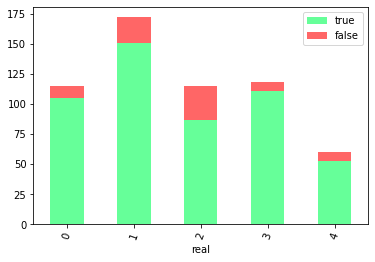

In [29]:
#fit svc

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto', probability=True))
clf.fit(train_X, train_y)
test_y_pred = clf.predict(test_X)
classes_plot(test_y, test_y_pred)

In [64]:
import pickle
with open('svm.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

0.7319223985890653


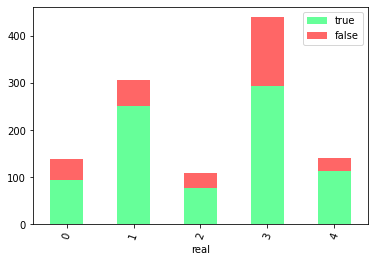

In [36]:
y_val_pred = clf.predict(X_val)
classes_plot(y_val, y_val_pred)
y_val_proba = clf.predict_proba(X_val)
y_onehot_val = pd.get_dummies(y_val).values

In [37]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_val.ravel(), y_val_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.91


In [41]:
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_val_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(5):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 5

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.92


In [42]:
macro_roc_auc_ovr = roc_auc_score(
    y_val,
    y_val_proba,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.92


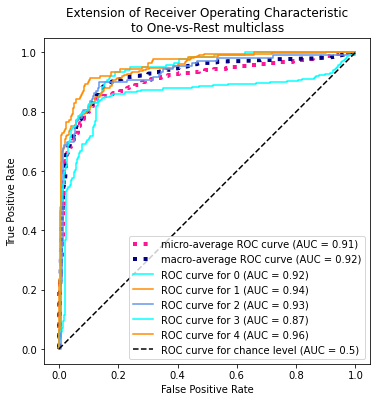

In [49]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(5), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_val[:, class_id],
        y_val_proba[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [59]:
sentences = df[['original_text','type','index']].apply(lambda x:prepare_split_text(x),axis=1)
sentences = pd.DataFrame.from_records(np.hstack([np.array(d) for d in sentences.values]))
sentences = pd.merge(df[['index','doc']],sentences)

In [60]:
sentences['token'] = sentences.text.progress_apply(get_embeddings)

100%|██████████| 6930/6930 [00:19<00:00, 356.01it/s]


In [88]:
token_data = np.asarray([a for a in sentences['token'].values])

full_predict = clf.predict_proba(token_data)
sentences['type_pred'] = np.argmax(full_predict,axis=1)
sentences['type_pred_proba'] = [d[0][d[1]] for d in zip(full_predict,np.argmax(full_predict,axis=1))]

In [224]:
doc_full = sentences.groupby(by=['doc'],as_index=False).type_pred.value_counts().drop_duplicates(['doc']).reset_index(drop=True)
doc_full['type_true'] = sentences.groupby(by=['doc'],as_index=False).type.value_counts()['type']
doc_full['true_count'] = sentences.groupby(by=['doc'],as_index=False).type.value_counts()['count']
doc_full['pred_confidence'] = doc_full['count']/doc_full['true_count']

In [197]:
(doc_full['type_pred']==doc_full['type_true']).value_counts()

True     119
False      1
dtype: int64

In [208]:
doc_full[doc_full['type_pred']!=doc_full['type_true']]

,doc,type_pred,count,type_true,true_count
52,67170dee29deff9bc80087a94aef7ea4.doc,2,46,1,91


In [206]:
df[df.doc==doc_full[doc_full['type_pred']!=doc_full['type_true']].doc.values[0]]

,index,doc,class_name,type,original_text,text,length
28,28,67170dee29deff9bc80087a94aef7ea4.doc,Договоры для акселератора/Договоры оказания услуг,1,\n\n Договор № ...,Договор № __г. Москва «__» _________ 2020 г.З...,18628


In [204]:
df[df.doc==doc_full[doc_full['type_pred']!=doc_full['type_true']].doc.values[0]].original_text.values

array(['\n\n                                Договор № __\n\n\nг. Москва                                           «__» _________ 2020 г.\n\nЗаказчик: ООО «Компания Заказчика» в лице генерального директора Фамилия\nИмя Отчество, действующего на основании устава,\n\nИсполнитель: ООО «Компания Исполнителя», в лице генерального директора\nФамилия Имя Отчество, действующего на основании устава,\n\nсовместно именуемые Стороны, заключили договор (далее — Договор) о\nследующем:\n\n      Предмет Договора\n\n   1. Исполнитель обязуется выполнять работы и оказывать услуги по заданиям\n      Заказчика, а Заказчик обязуется принимать и оплачивать их.\n\n      Заказы\n\n   2. Договор является рамочным. Стороны согласуют объём, срок и порядок\n      выполнения заданий путём подписания заказов к Договору (далее —\n      Заказы).\n   3. Заказчик вправе изменять задание по Договору. При этом Исполнитель\n      вправе изменить стоимость и срок выполнения задания. Стороны оформляют\n      такие изменения 

In [211]:
# Итог:
# Модель допустила одну ошибку, спутав класс вышеуказанного договора.
# Предсказанный класс: Договор подрядра.
# Рельно размеченный класс: Договор оказания услуг.

# Исходя из вышеизложенного текста договора, создание сайта можно отнести как к категории договора, 
# так и к категории подряда. Формулировки абзацев очень сильно схожи для этих двух тем, как и направление деятельности.
# Создание сайта можно рассматривать и как "подряд", и как "оказание услуги". 

# Таким образом можно сделать вывод что алгоритм показал 100% точность на текущих данных.

In [252]:
classes_dict = {0:'Договоры поставки',
 1: 'Договоры оказания услуг',
 2: 'Договоры подряда',
 3: 'Договоры аренды',
 4: 'Договоры купли-продажи'}

submit_data = {'submit_data':[]}
for i,d in doc_full.iterrows():
    submit_doc = {}
    submit_doc['doc'] = d.doc
    submit_doc['class'] = classes_dict.get(d.type_pred)
    submit_doc['confidence_level'] = d.pred_confidence
    submit_doc['interpretation']=sentences[sentences.doc==d.doc].sort_values(by='type_pred_proba',ascending=False).iloc[:3].text.values.tolist()
    submit_data['submit_data'].append(submit_doc)

In [253]:
import json

with open('PYC_submit.json','w') as f:
    json.dump(submit_data,f)